## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [1]:
%matplotlib inline

import os
import sys
import copy
import multiprocessing

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.operations import create_visibility, sum_visibility
from arl.visibility.iterators import vis_timeslice_iter, vis_wstack_iter
from arl.util.testing_support import create_named_configuration
from arl.util.timing import timing

from matplotlib import pyplot as plt

from arl.skycomponent.operations import create_skycomponent, find_skycomponents, \
    find_nearest_component, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, create_empty_image_like, qa_image, smooth_image
from arl.image.iterators import raster_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *
from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 95865 rows, 0.009 GB


In [4]:
advice = advise_wide_field(vt)

advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Facet field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for facet = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for facet = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wide_field: Frequency sampling for full image = 29212.6 (Hz)
advice_wide_field: Frequency sampling for fac

Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 32
Component at (239.000000, 15.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 4.74378292, -51.0209895)>
Component at (207.000000, 15.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 7.66144755, -51.22149637)>
Component at (175.000000, 15.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 10.5917361, -51.35530369)>
Component at (143.000000, 15.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 13.52971731, -51.42224945)>
Component at (111.000000, 15.000000) [0-r

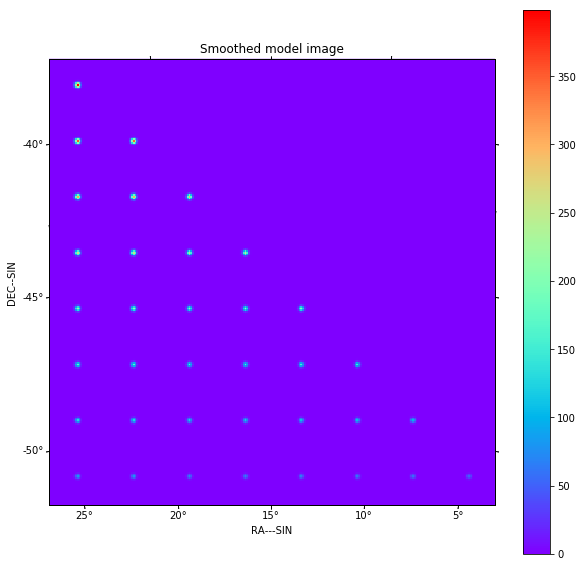

In [5]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1, 
                                     polarisation_frame=PolarisationFrame('stokesI'))
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            predict_skycomponent_visibility(vt, comp)
            insert_skycomponent(model, comp)
        
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


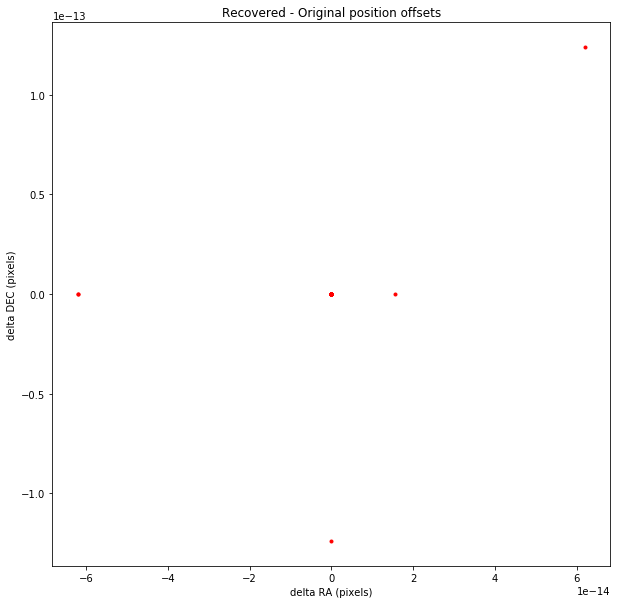

In [6]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp = find_nearest_component(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Predict the visibility using the different approaches.

create_visibility: 95865 rows, 0.009 GB
predict_2d: predict using 2d transform
func:'predictit' took: 1.6263 sec


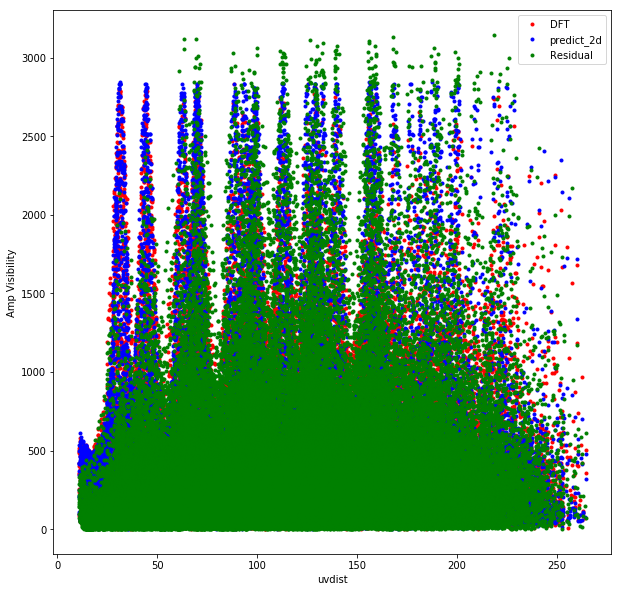

create_visibility: 95865 rows, 0.009 GB
predict_timeslice: predicting using time slices
predict_with_vis_iterator: Processing chunks
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 33.7 to 0.0 m
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 28.0 to 0.0 m
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 33.8 to 0.0 m
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 46.2 to 0.0 m
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from

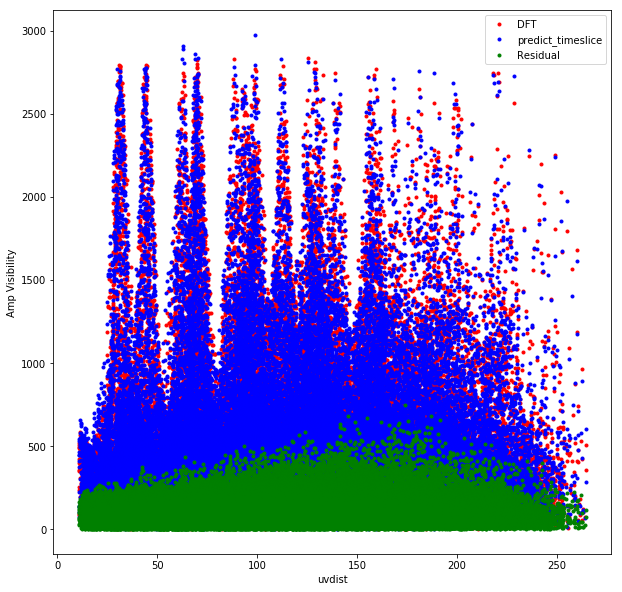

create_visibility: 95865 rows, 0.009 GB
predict_wstack: predicting using w slices
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Facet field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for facet = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for facet = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wide_field: Frequency sa

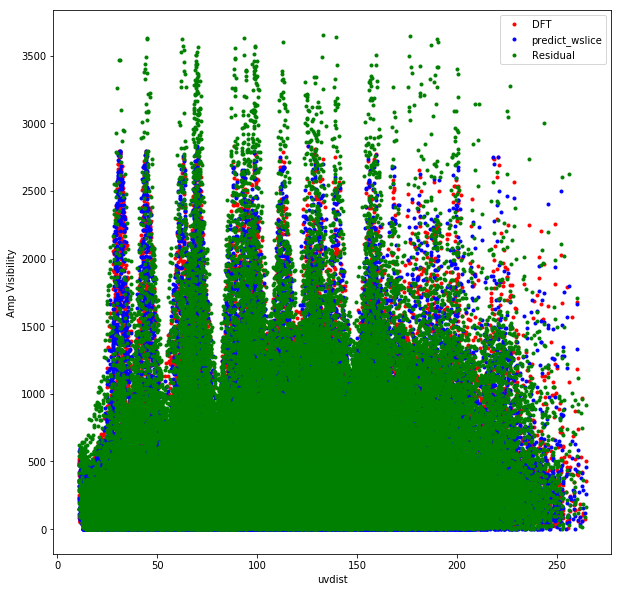

create_visibility: 95865 rows, 0.009 GB
predict_facets: Predicting by image facets
predict_with_image_iterator: Predicting by image partitions
raster: predicting using 8 x 8 image partitions
raster: spacing of raster (32, 32)
raster: partition (0, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (1, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 22.33855245, -51.22149637)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (2, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 19.4082639, -51.35530369)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (3, 0) o

raster: partition (0, 4) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.91639614, -43.72937783)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (1, 4) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.37476195, -43.90270873)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (2, 4) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 18.82724608, -44.01824481)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (3, 4) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 16.27614945, -44.07600819)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


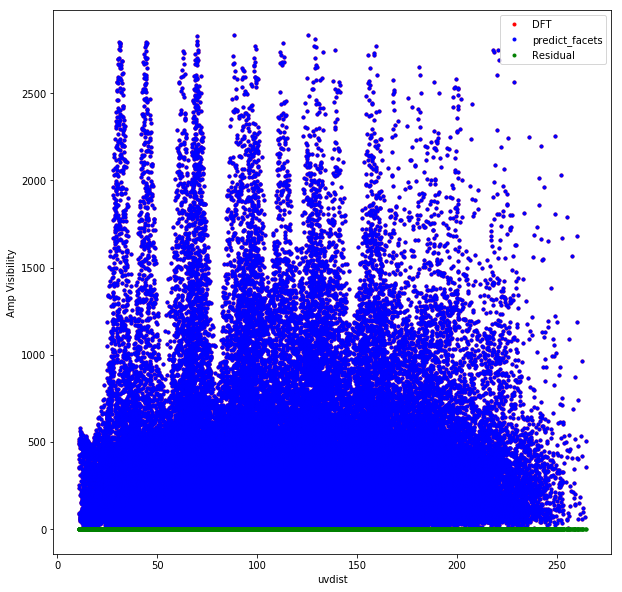

create_visibility: 95865 rows, 0.009 GB
predict_wprojection: predict using wprojection
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Facet field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for facet = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for facet = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wide_field: Frequen

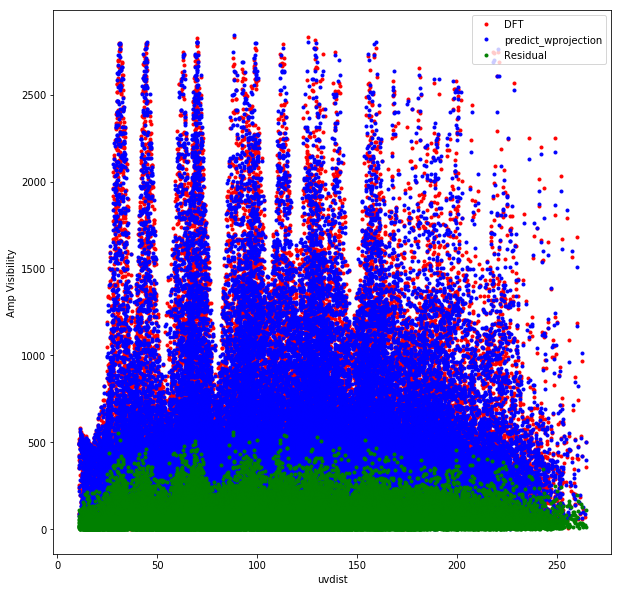

In [7]:
processors = [predict_2d, predict_timeslice, predict_wstack, predict_facets, predict_wprojection]

for processor in processors:
    
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")   
    vtpredict = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                                  weight=1.0, phasecentre=phasecentre,
                                 polarisation_frame=PolarisationFrame('stokesI'))
    @timing
    def predictit():
        return processor(vtpredict, model, nprocessor=1, timeslice=1.0,
                          padding=2, oversampling=4, facets=8, wstack=advice['w_sampling_primary_beam'],
                        wstep=advice['w_sampling_primary_beam'])

    vtpredict = predictit()
        
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=processor.__name__)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]-vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()

Make the image using the different approaches. We will evaluate the results using a number of plots:

- The error in fitted versus the radius. The ideal result is a straightline fitted: flux = DFT flux
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.

The sampling in w is set to provide 2% decorrelation at the half power point of the primary beam.


In [ ]:
processors = [invert_wstack, invert_2d, invert_timeslice, invert_facets, invert_wprojection]

for processor in processors:

    targetimage = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1,
                                              polarisation_frame=PolarisationFrame('stokesI'))
    @timing
    def makeimage():
        return processor(vt, targetimage, timeslice='auto', padding=2, oversampling=4,
                         facets=4, wstack=advice['w_sampling_primary_beam'], 
                         wstep=advice['w_sampling_primary_beam'])
        
    targetimage, sumwt = makeimage()

    
    show_image(targetimage)
    plt.title(processor.__name__)
    plt.show()
    
    print("Dirty Image %s" % 
          qa_image(targetimage, context="imaging-fits notebook, using processor %s" %(processor.__name__)))
    
    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' %(results_dir, processor.__name__))
    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)

    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        dft_flux = sum_visibility(vt, comp.direction)[0] 
        err = (comp.flux[0,0] - dft_flux ) / dft_flux
        plt.plot(distance, err, '.', color='r')
    plt.ylabel('Fractional error of image vs DFT')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.title("Fractional error in %s recovered flux vs distance from phasecentre" % (processor.__name__))
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp = find_nearest_component(comps[i].direction, original_comps)
            plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/targetimage.wcs.wcs.cdelt[0], 
                     (comps[i].direction.dec.value - ocomp.direction.dec.value)/targetimage.wcs.wcs.cdelt[1], 
                     '.', color='r')  

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % (processor.__name__))
        plt.show()